# Sequências - Aula Prática
## Word2Vec

Neste notebook iremos trabalhar um pouco com a parte introdutória de modelos de linguagem, implementando um modelo `Word2Vec`, que utiliza a arquitetura *Constant Bag-of-Words* (CBOW), em uma base de dados simples.

- **Importante:** caso esteja rodando esse notebook no ambiente da Tatu, favor executar a seguinte célula. Caso contrário, basta ignorar a sua execução.

In [1]:
%load_ext nbproxy

Chave:  ewav
Senha: ········



Variáveis de ambiente http_proxy e https_proxy configuradas!


## Importação de pacotes

In [2]:
!pip install conllu --quiet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import zipfile

from torch.utils.data import Dataset, DataLoader
from conllu import parse

In [4]:
# Definindo se o código será executado na CPU ou na GPU
has_cuda = torch.cuda.is_available()
device = torch.device('cuda' if has_cuda else 'cpu')

print('O código será executado em:', device)

O código será executado em: cuda


A representação de palavras ou termos por *embeddings* é um dos conceitos mais fundamentais de Deep Learning em Processamento de Linguagem Naturais. O [*word2vec*](https://arxiv.org/pdf/1301.3781.pdf), proposto por Tomas Mikolov et al. na Google em 2013, foi um dos modelos iniciais utilizados para se aprender esse tipo de representação. Apesar de já ser considerado antigo, os conceitos desenvolvidos nas primeiras publicações ainda são úteis para o desenvolvimento de modelos mais avançados.

A ideia central do *word2vec* é a de que o significado de uma palavra está diretamente relacionado às palavras ao redor da mesma, ou seja, seu **contexto**. Por exemplo, podemos imaginar que as palavras que se encaixam em uma frase do tipo `hoje eu comi ___ no café da manhã` tenham uma certa proximidade de significado em alguns aspectos, e portanto possuam um grau de similaridade entre seus *embeddings*.

O artigo original propõe duas arquiteturas distintas para isso: **CBOW** (Continuous Bag-of-Words) e **Skip-Gram**, sendo a imagem a seguir uma representação do esquema por trás dessas arquiteturas.

<img width=600 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/cbow_and_skipgram_scheme.png?raw=true">

Pelo esquema acima conseguimos perceber que a arquitetura CBOW recebe como entrada o conjunto de termos que formam o contexto, representados por $w(t-2) \dots w(t+2)$, e tenta prever o termo central da sequência, no caso $w(t)$. Por outro lado, Skip-Gram tenta prever os termos do contexto com base na palavra central.

> Apesar dessa diferença, o objetivo em ambos os casos é gerar os *embeddings* dos termos. Portanto o que importa para nós no final são as representações aprendidas pelo modelo durante o treinamento e armazenados como parâmetros da rede.

### Implementação de um Word2Vec (CBOW)

Começaremos buscando um conjunto de dados e gerando um vocabulário a partir disso.

In [5]:
with open("/pgeoprj2/ciag2024/dados/Petro1.conllu", "r", encoding="utf-8") as f:
    data = f.read()

text = parse(data)

sentences = []
for sentence in text:
    t = []
    last = -1
    for token in sentence:
        if type(token['id']) is tuple:
            last = token['id'][-1]
        if token['form'] and token['upostag'] != 'PUNCT' and (type(token['id']) is tuple or token['id'] > last):
            t.append(token["form"])
    sentences.append(" ".join(t))

for i in range(1, 10):
    print(sentences[i])

Um dos fatores que determina a qualidade da gasolina pirolisada e de suas frações de destilação e hidrogenação na indústria de petróleo é o teor de dienos conjugados assim como o das olefinas de compostos aromáticos e ramificados POLÁK et al. 1986 VELASCO-ARJONA et al. 1998 e SWARIN et al. 1989
Estes compostos diminuem a qualidade dos produtos petrolíferos devido à sua fácil polimerização já que as suas ligações duplas conjugadas apresentam alta reatividade
Além dos dienos conjugados o estireno e seus derivados devido à conjugação da ligação dupla com o sistema aromático também apresentam forte tendência à polimerização POLÁK et al. 1986
Já foi evidenciado que existe uma forte correlação entre os depósitos formados nos injetores de automóveis e o teor de dienos conjugados presente nos combustíveis utilizados POLÁK et al. 1986 e VELASCO-ARJONA et al. 1998
A tendência que uma gasolina apresenta em formar goma durante sua estocagem ou até mesmo durante seu consumo depende de vários fatore

Para definir o nosso vocabulário, primeiro iremos realizar um processo de "tokenização" do texto definido anteriormente, onde, por simplicidade, definimos que o nosso *token* será igual à uma palavra completa. Após isso, o nosso vocabulário será definido como o conjunto de *tokens* únicos, podendo ser obtidos a partir de um `set`.

> **Importante**: O *pipeline* de processamento de dados textuais pode conter diversas outras etapas além da "tokenização", como por exemplo a remoção de *stop words*, ou seja, palavras que são muito comuns na linguagem e que não carregam muita informação útil. Porém, para manter a simplicidade do notebook, iremos apenas realizar a etapa de "tokenização" do texto. Para mais informações sobre *stop words* consulte o seguinte [link](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a), assim como esse outro [link](https://medium.com/analytics-vidhya/nlp-preprocessing-pipeline-what-when-why-2fc808899d1f) para um detalhamento maior do *pipeline* de processamento de dados em NLP.

1. Implemente a função `build_vocabulary`.

In [6]:
def build_vocabulary(sentences: list):
    tokenized_lines = []
    for line in sentences:
        tokens = line.split(' ')  # processo de tokenização do texto
        tokenized_lines.append(tokens)

    vocabulary = set()
    for tokens in tokenized_lines:
        vocabulary.update(set(tokens))

    return tokenized_lines, vocabulary

tokenized_lines, vocabulary = build_vocabulary(sentences)
print(f'Temos um total de {len(vocabulary)} tokens no nosso vocabulário')

Temos um total de 4517 tokens no nosso vocabulário


In [8]:
# tokenized_lines/

Podemos então definir dicionários para mapear um índice numérico para cada termo do vocabulário, assim como retornar o termo dado um índice.

> **Importante**: Não confundir esse índice numérico com a posição da palavra no texto original! Ele é apenas um mapeamento entre palavra e número.

<img width=600 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/vocabulario.png?raw=true" />

In [14]:
# Utilizaremos comprehension to Python para fazer um código one-liner
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for idx, word in enumerate(vocabulary)}

print('Índice da palavra "petróleo" no dicionário:', word2idx['petróleo'])
print('Palavra do índice 150 do dicionário:', idx2word[150])

Índice da palavra "petróleo" no dicionário: 2104
Palavra do índice 150 do dicionário: agudo


Com isso, conseguimos definir uma função que cria tensores para um contexto contendo múltiplos termos do nosso vocabulário!

2. Implemente a função `make_context_tensor`. Ela recebe uma string de contexto e deve retornar um tensor que representa o contexto.

In [15]:
def make_context_tensor(context: str, word2idx: dict[str, int]):
    tokens = context.split(' ')
    idxs = [word2idx[token] for token in tokens]  # para cada token, iremos recuperar o seu índice numérico

    return torch.tensor(idxs, dtype=torch.long)

context = 'qualidade dos produtos petrolíferos'
make_context_tensor(context, word2idx)

tensor([3981, 2808,  335, 3203])

#### Definição de uma base de dados simples

A partir do que foi desenvolvido até então, conseguimos definir uma base de dados simples composta por pares `(context, target)` para treinar o nosso modelo *word2vec*. Iremos percorrer o texto completo, tomando termo a termo como o alvo e as palavras ao redor como seu contexto.

> Para o exemplo dessa aula, utilizaremos uma janela de 2 termos em cada direção para delimitar o contexto. É recomendável alterar essa janela e verificar a qualidade final do nosso modelo. Além disso, não estamos preocupados aqui em criar um conjunto de treino, validação e teste, mas sim de apenas entender o funcionamento de modelos *word2vec*.

In [16]:
class EmbeddingsDataset(Dataset):
    def __init__(self, sentences: list, context_size: int = 2):
        tokenized_lines, vocabulary = build_vocabulary(sentences)

        # Definindo dicionários para mapear palavra -> número e vice-versa
        self.word2idx = {word: idx for idx, word in enumerate(vocabulary)}
        self.idx2word = {idx: word for idx, word in enumerate(vocabulary)}

        self.data = []
        for tokens in tokenized_lines:
            for i in range(context_size, len(tokens) - context_size):
                left_words = [tokens[i-j] for j in range(context_size, 0, -1)]
                right_words = [tokens[i+j] for j in range(1, context_size + 1)]

                target = tokens[i]
                context = left_words + right_words
                context = ' '.join(context)  # convertendo de lista para string

                self.data.append((context, target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        context, target = self.data[idx]
        context_tensor = make_context_tensor(context, self.word2idx)
        target_tensor = torch.tensor(self.word2idx[target], dtype=torch.long)

        return context_tensor, target_tensor

In [17]:
dataset = EmbeddingsDataset(sentences, context_size=2)
print('Primeiro exemplo de treino:', dataset[0])

Primeiro exemplo de treino: (tensor([1872, 2808, 4496,  327]), tensor(4405))


In [18]:
# Podemos usar o dicionário idx2word para ver qual que é o contexto e palavra alvo
context, target = dataset[0]

context = [dataset.idx2word[idx.item()] for idx in context]
context = ' '.join(context)

target = dataset.idx2word[target.item()]

print('Primeiro exemplo de treino:', (context, target))

Primeiro exemplo de treino: ('Um dos que determina', 'fatores')


#### Definição da arquitetura

A nossa arquitetura será composta por uma camada `nn.Embedding`, na qual aprenderemos as representações dos termos, seguida de algumas camadas lineares, com o propósito de realizar a previsão da palavra alvo.

> A camada `nn.Embedding` é similar à uma camada `nn.Linear`, sem o termo de viés, no sentido de também ser definida como uma matriz. Porém, diferentemente da `nn.Linear`, nós não realizamos um produto matricial com a matriz produzida pela camada de *embedding*, mas sim realizamos uma operação de *lookup* na matriz, como se ela fosse uma tabela, como observado na imagem a seguir.

<img width=600 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/lookup_embedding.png?raw=true">

**Importante:** Note que na imagem acima o produto matricial do vetor de entrada com a matriz de *embeddings* dará o mesmo resultado, afinal um vetor de entrada *one-hot encoded* irá efetivamente selecionar uma linha, ou coluna, da nossa matriz. Porém, na prática ainda é preferível a utilização da camada `nn.Embedding` ao invés de uma camada `nn.Linear` com o viés desabilitado por questões de eficiência. Para mais detalhes, consulte o seguinte [link](https://medium.com/@gautam.e/what-is-nn-embedding-really-de038baadd24).

In [19]:
import torch
import torch.nn as nn

x = torch.tensor([0, 1, 2])
embedding = nn.Embedding(10, 100)  # 10 palavras com 100 de conceito

embedding(x).shape

torch.Size([3, 100])

3. Implemente a arquitetura `CBOW`.

In [24]:
class CBOW(torch.nn.Module):
    def __init__(self, vocabulary_size: int, embedding_dim: int):
        super().__init__()

        self.embedding = nn.Embedding(vocabulary_size, embedding_dim)
        self.linear = nn.Sequential(nn.Linear(embedding_dim, vocabulary_size//2), nn.ReLU(), 
                                    nn.Linear(vocabulary_size//2, vocabulary_size)
                                   )
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x: torch.Tensor):
        embeds = self.embedding(x)
        embeds = torch.sum(embeds, dim=1)  # agregando os embeddings (informação coletiva do contexto)

        out = self.linear(embeds)
        out = self.softmax(out)
        return out

#### Treinamento do modelo

Como estamos utilizando uma camada de `LogSoftmax` no final da nossa rede, temos que utilizar a função de perda `NLLLoss` ao invés da `CrossEntropyLoss`, já que a primeira espera que a saída do modelo sejam **log-probabilidades** ao invés de **logits** (saídas não ativadas), como esperado pela segunda função de perda.

4. Treine o modelo `CBOW` com o `EmbeddingsDataset`.

In [26]:
batch_size = 4
num_epochs = 100
learning_rate = 0.001

dataset = EmbeddingsDataset(sentences, context_size=2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

embedding_dim = 16
model = CBOW(len(vocabulary), embedding_dim)
model = model.to(device)

criterion = nn.NLLLoss()  # negative log-likelihood
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    epoch_loss = 0

    for context, target in dataloader:
        context = context.to(device)
        target = target.to(device)

        outputs = model(context)
        loss = criterion(outputs, target)
        epoch_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        mean_loss = epoch_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs} => mean loss: {mean_loss:.5f}')

Epoch 5/100 => mean loss: 4.38396
Epoch 10/100 => mean loss: 1.88568
Epoch 15/100 => mean loss: 0.71912
Epoch 20/100 => mean loss: 0.30431
Epoch 25/100 => mean loss: 0.14402
Epoch 30/100 => mean loss: 0.09820
Epoch 35/100 => mean loss: 0.06805
Epoch 40/100 => mean loss: 0.05704
Epoch 45/100 => mean loss: 0.05568
Epoch 50/100 => mean loss: 0.04241
Epoch 55/100 => mean loss: 0.04224
Epoch 60/100 => mean loss: 0.04313
Epoch 65/100 => mean loss: 0.03712
Epoch 70/100 => mean loss: 0.05070
Epoch 75/100 => mean loss: 0.03754
Epoch 80/100 => mean loss: 0.03024
Epoch 85/100 => mean loss: 0.04246
Epoch 90/100 => mean loss: 0.03538
Epoch 95/100 => mean loss: 0.03275
Epoch 100/100 => mean loss: 0.03041


Agora podemos testar a rede, fornecendo um contexto e verificando qual palavra o modelo prevê como termo central!

In [27]:
context = 'metade da de hidrogênio'
context_vector = make_context_tensor(context, dataset.word2idx)

# Convertendo para executar no dispositivo correto e adicionando batch size
context_vector = context_vector.to(device)
context_vector = context_vector.unsqueeze(dim=0)

outputs = model(context_vector)
print(f'Contexto:', context)
print(f'Predição:', dataset.idx2word[torch.argmax(outputs[0]).item()])

Contexto: metade da de hidrogênio
Predição: produção


- Além disso conseguimos visualizar o *embedding* gerado para a predição do modelo!

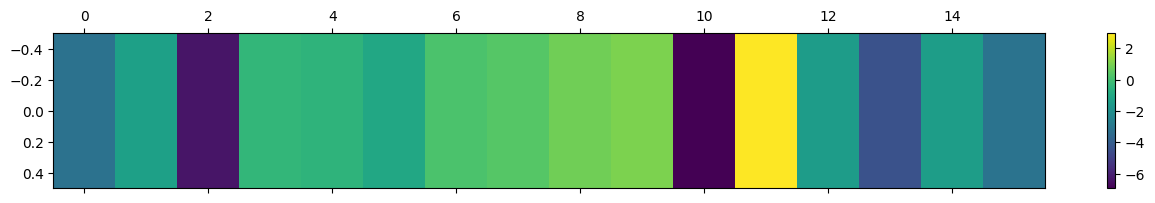

In [16]:
word = torch.LongTensor([torch.argmax(outputs[0])]).to(device)
embedded_word = model.embedding(word)

plt.matshow(embedded_word.detach().cpu().numpy(), aspect='auto')
plt.colorbar()
plt.show()

- Também podemos realizar uma visualização do espaço latente produzido pela camada de *embedding* do nosso `word2vec`. Para isso, realizaremos um TSNE para recuperar os 2 componentes principais do vetor de *embedding* e visualizar esse espaço em 2D.

In [17]:
words = []

for token in vocabulary:
    word = torch.LongTensor([dataset.word2idx[token]]).to(device)
    embedded_word = model.embedding(word)
    embedded_word = embedded_word.squeeze()  # removendo dimensões unitárias
    embedded_word = embedded_word.detach().cpu().numpy()  # convertendo para numpy na cpu

    words.append(embedded_word)

words = np.array(words)
print('Dimensão dos dados:', words.shape)

Dimensão dos dados: (4517, 16)


In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
components = tsne.fit_transform(words[:400])

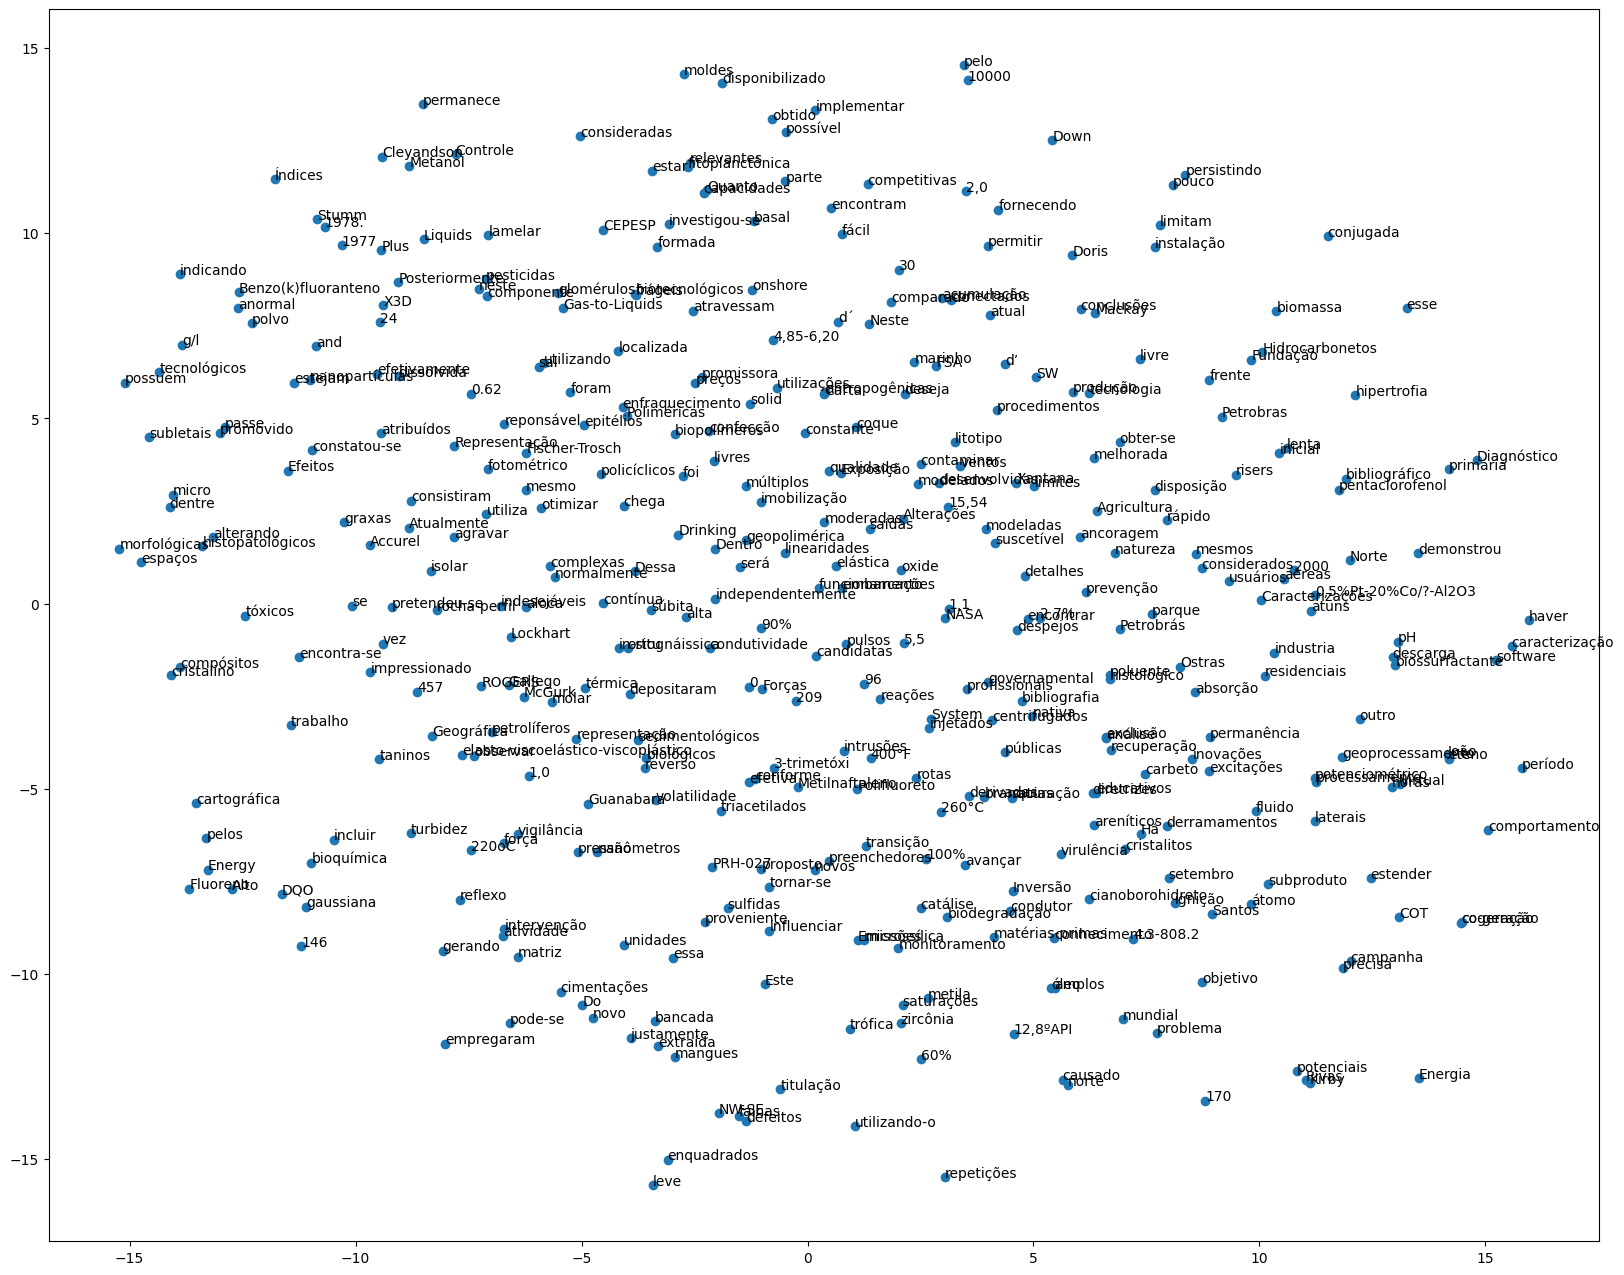

In [19]:
fig, ax = plt.subplots(figsize=(20, 16))
ax.scatter(components[:, 0], components[:, 1])

for i, token in enumerate(vocabulary):
    if i > 399:
        break
    ax.annotate(token, (components[i, 0], components[i, 1]))